# BigMac Index Linear Regression Pipline 

In [90]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

## Data Loading & Cleaning

In [91]:
# Load Data
CSV_PATH = "cleaned_bigmac_data_linearreg.csv"
df = pd.read_csv(CSV_PATH).drop(columns = ["Unnamed: 0"], errors = "ignore")

# Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# Keep only relevant columns
df = df[["country", "iso_a3", "currency_code", "local_price", "dollar_ex", "dollar_price", "year"]]

# Drop missing values
df = df.dropna(subset = ["local_price", "dollar_ex", "dollar_price", "year"])

In [92]:
# Convert datatypes
df["local_price"] = df["local_price"].astype(float).round(2)
df["dollar_ex"] = df["dollar_ex"].astype(float)
df["dollar_price"] = df["dollar_price"].astype(float).round(2)
df["year"] = df["year"].astype(int)

# Remove duplicates
df = df.drop_duplicates(subset = ["country", "year"])

print("Data cleaned for Linear Regression")
print("Shape:", df.shape)
print(df.head())

Data cleaned for Linear Regression
Shape: (1099, 7)
       country iso_a3 currency_code  local_price  dollar_ex  dollar_price  \
0    Argentina    ARG           ARS         2.50       1.00          2.50   
1    Australia    AUS           AUD         2.59       1.68          1.54   
2       Brazil    BRA           BRL         2.95       1.79          1.65   
3       Canada    CAN           CAD         2.85       1.47          1.94   
4  Switzerland    CHE           CHF         5.90       1.70          3.47   

   year  
0  2000  
1  2000  
2  2000  
3  2000  
4  2000  


## Feature Engineering

In [93]:
# Predict "dollar_price" using local_price + dollar_ex
X = df[["local_price", "dollar_ex"]]
y = df["dollar_price"].round(2)

# Split dataset into Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Features and target prepared")

Features and target prepared


In [94]:
# Model Training
model = LinearRegression()
model.fit(X_train, y_train)

print("Linear Regression model trained")
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

Linear Regression model trained
Intercept: 3.273807665066122
Coefficients: [ 4.73753960e-07 -1.75272494e-06]


In [95]:
# Predict dollar_price for all rows at once
df["predicted_price"] = model.predict(df[["local_price", "dollar_ex"]]).round(2)

In [96]:
# Model Evaluation
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model evaluated")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Model evaluated
Mean Squared Error: 2.4987
R² Score: -0.0112


## Visualization

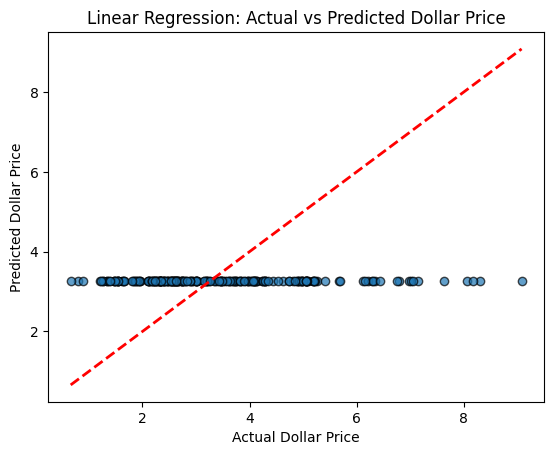

In [97]:
# Actual vs Predicted Scatter
plt.scatter(y_test, y_pred, alpha=0.7, edgecolor = "k")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw = 2)  # Perfect prediction line
plt.xlabel("Actual Dollar Price")
plt.ylabel("Predicted Dollar Price")
plt.title("Linear Regression: Actual vs Predicted Dollar Price")
plt.show()

Compares the model's predictions against the real Big Mac prices in USD.

Shows how well the linear regression model predicts prices.

Points close to the red dashed line indicate accurate predictions.

Context:

- If most countries’ points lie near the line, the model captures the relationship between local price, exchange rate, and USD price well.

- Outliers indicate countries where the model underestimates or overestimates the Big Mac price.

Skipping United Kingdom - no data in dataset


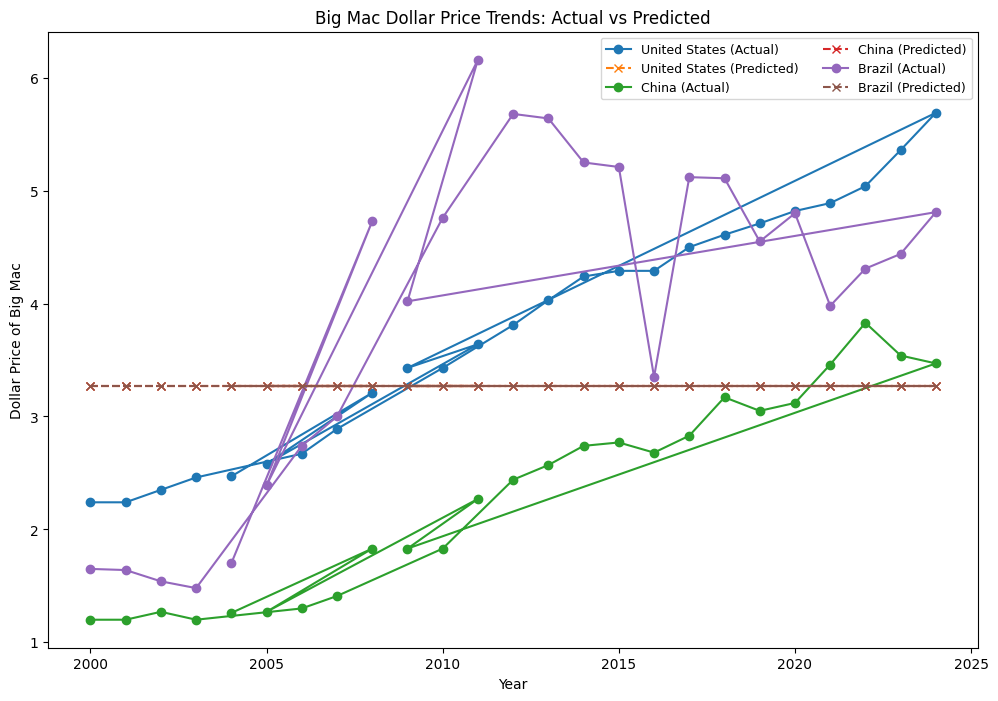

In [98]:
# Trends over Time for Selected Countries
selected_countries = ["United States", "United Kingdom", "China", "Brazil"]

plt.figure(figsize = (12, 8))

for country in selected_countries:
    country_df = df[df["country"] == country].copy()
    
    if country_df.empty:
        print(f"Skipping {country} - no data in dataset")
        continue

    # Actual vs Predicted
    plt.plot(country_df["year"], country_df["dollar_price"], marker = "o", label = f"{country} (Actual)")
    plt.plot(country_df["year"], country_df["predicted_price"], marker = "x", linestyle = "--", 
             label = f"{country} (Predicted)")

plt.xlabel("Year")
plt.ylabel("Dollar Price of Big Mac")
plt.title("Big Mac Dollar Price Trends: Actual vs Predicted")
plt.legend(loc = "best", fontsize = 9, ncol = 2)  # Fixed ncol typo
plt.show()

Shows yearly Big Mac prices (actual vs predicted) for a handful of representative countries.

Compares model predictions with reality for key economies or interesting case studies.

Context:

- Helps see how well the model tracks price changes over time in specific countries.

- Highlights years where a country's Big Mac price deviates substantially from predictions (e.g., sudden currency fluctuation or economic shock).

- Useful for visual storytelling: you can point out trends in developed vs emerging markets.

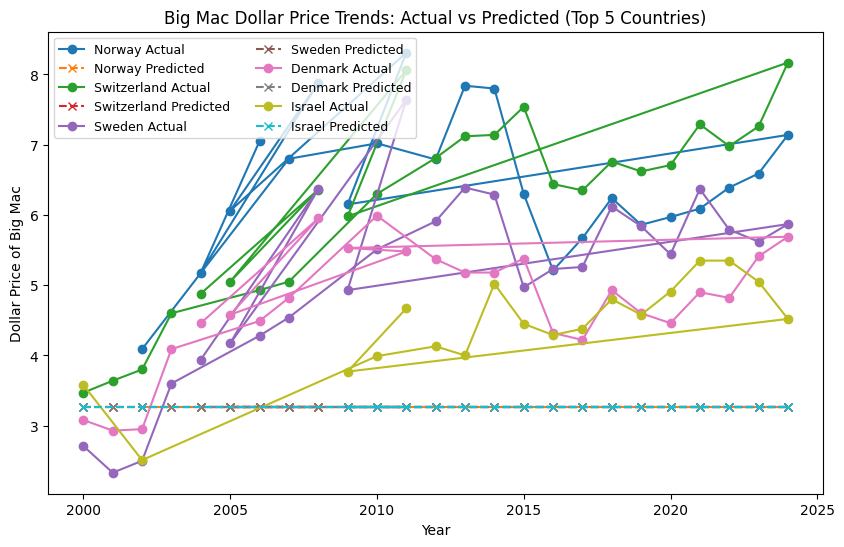

In [99]:
# Time-Series per Country (top 5 countries by GDP or price)
top_countries = df.groupby("country")["dollar_price"].mean().sort_values(ascending=False).head(5).index

plt.figure(figsize=(10, 6))
for country in top_countries:
    country_df = df[df["country"] == country]
    plt.plot(country_df["year"], country_df["dollar_price"], marker = "o", label = f"{country} Actual")
    plt.plot(country_df["year"], country_df["predicted_price"], marker = "x", linestyle = "--", 
             label = f"{country} Predicted")

plt.xlabel("Year")
plt.ylabel("Dollar Price of Big Mac")
plt.title("Big Mac Dollar Price Trends: Actual vs Predicted (Top 5 Countries)")
plt.legend(loc = "best", fontsize = 9, ncol = 2)
plt.show()

Focuses on the top 5 countries with the highest average Big Mac prices.

Plots actual vs predicted USD prices for these countries over time.

Context:

- Highlights the most expensive markets, where PPP deviations may be more pronounced.

- Allows comparison of high-price economies to see which ones align with model expectations and which deviate.

- Good for identifying potential overvaluation in rich economies or unique price trends over time.

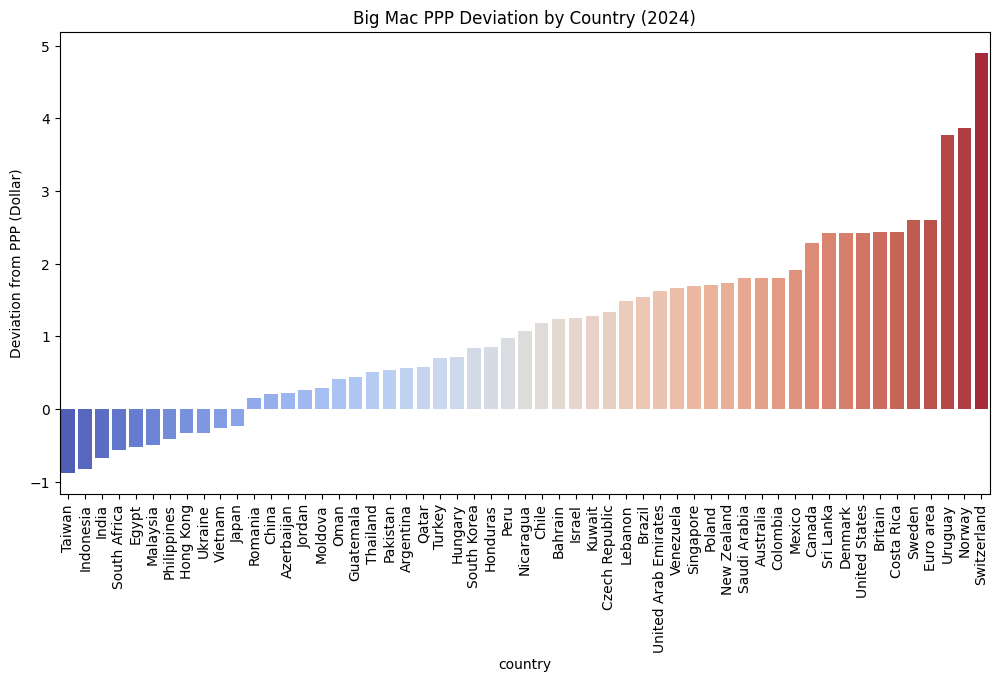

In [100]:
# Overvalued vs Undervalued Currencies
df["ppp_deviation"] = df["dollar_price"] - df["predicted_price"]
latest_year = df["year"].max()
latest_df = df[df["year"] == latest_year].sort_values("ppp_deviation")

plt.figure(figsize=(12, 6))
sns.barplot(
    x = "country", 
    y = "ppp_deviation", 
    data = latest_df, 
    palette = "coolwarm",
    order = latest_df["country"]  # keep the sorted order
)
plt.xticks(rotation = 90)
plt.ylabel("Deviation from PPP (Dollar)")
plt.title(f"Big Mac PPP Deviation by Country ({latest_year})")
plt.show()

Compares how far each country’s actual Big Mac price deviates from the predicted price based on local price and exchange rate.

Positive deviation → actual price higher than predicted.

Negative deviation → actual price lower than predicted.

Context:

- Highlights overvalued and undervalued currencies relative to the model’s expectation.

- Useful for quick cross-country comparisons in a specific year.

In [101]:
# Choropleth Map of PPP Deviation
fig = px.choropleth(
    latest_df,
    locations = "iso_a3",
    color = "ppp_deviation",
    hover_name = "country",
    hover_data = {"dollar_price": True, "predicted_price": True},
    color_continuous_scale = px.colors.diverging.RdBu,
    color_continuous_midpoint = 0,
    title = f"Global PPP Deviation ({latest_year})"
)
fig.update_layout(width = 900, height = 525)
fig.show()

Shows the geographical distribution of over- and undervaluation worldwide.

Countries are color-coded based on their deviation from predicted Big Mac price.

Context:

- Provides a global perspective on purchasing power differences.

- Makes it visually obvious which regions have stronger or weaker currencies relative to the model.

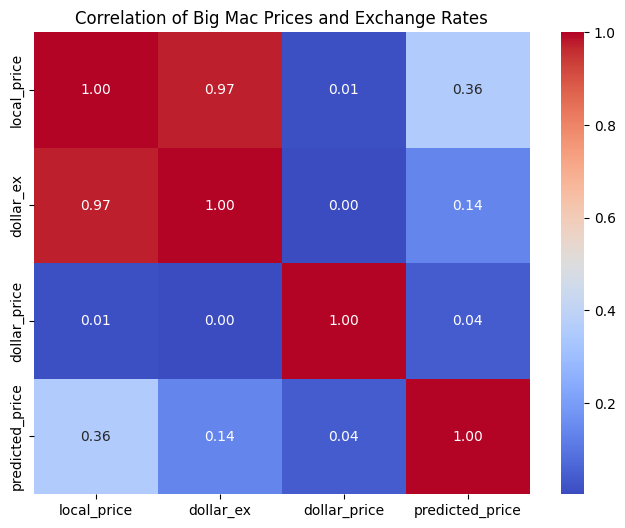

In [102]:
# Correlation Heatmap
plt.figure(figsize = (8,6))
corr = df[["local_price", "dollar_ex", "dollar_price", "predicted_price"]].corr()
sns.heatmap(corr, annot = True, cmap = "coolwarm", fmt = ".2f")
plt.title("Correlation of Big Mac Prices and Exchange Rates")
plt.show()

Shows correlations between variables: local_price, dollar_ex, dollar_price, and predicted_price.

Context:

- Helps identify how strongly local price and exchange rate relate to the USD price.

- Useful for understanding relationships that the model leverages.

- Strong correlations indicate predictors are effective; weak correlations suggest other factors might influence the USD price.